In [1]:
import os, sys

import matplotlib.pyplot as plt
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)


import numpy as np
from scipy.spatial import distance_matrix
from src.pso_gen_ring import Swarm
from src.graph import Graph

In [2]:
from IPython.core.display_functions import clear_output

import os
from scipy.spatial import distance_matrix
from src.graph import Graph


def read_tsp_file(file_path: str) -> np.ndarray:
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
        num_cities = int(lines[0])
        coords = []
        for line in lines[1:num_cities + 1]:
            x, y = map(float, line.split())
            coords.append([x, y])

        return np.array(coords)

4999 430.244021857754


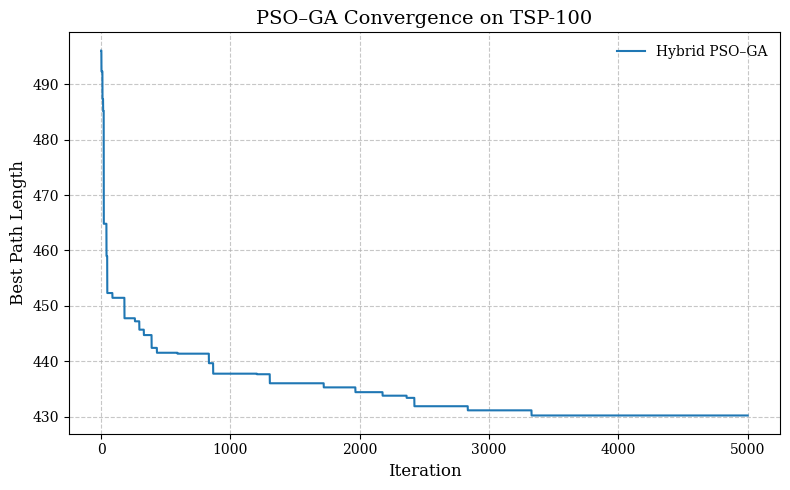

In [3]:
import matplotlib.pyplot as plt

coords = read_tsp_file('../data/tsp_51_1')
dist_mat = distance_matrix(coords, coords)
graph = Graph(dist_mat, coords, eval_nn=True)

pso = Swarm(graph, particle_count=200, r=50, alpha=0.4, c1=0.6, c2=0.4)
output = pso.solve(iterations=5000)
history = output.history

plt.style.use('default')
plt.rc('font', family='serif')

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(history) + 1), history, linewidth=1.5, label='Hybrid PSO–GA')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best Path Length', fontsize=12)
plt.title('PSO–GA Convergence on TSP-100', fontsize=14)
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('pso_ga_convergence_tsp100.pdf', format='pdf', dpi=300)
plt.show()


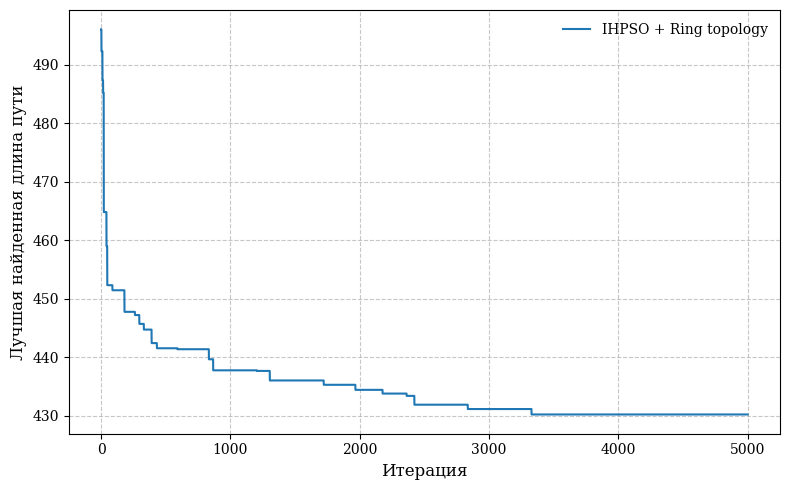

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(history) + 1), history, linewidth=1.5, label='IHPSO + Ring topology')
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Лучшая найденная длина пути', fontsize=12)
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ihpso_ring_convergence.pdf', format='pdf', dpi=300)
plt.show()

In [10]:
import pandas as pd
import numpy as np
import time
import random
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import current_process
from collections import defaultdict

datasets = ['tsp_51_1', 'tsp_100_3', 'tsp_200_2']
n_runs = 10
iterations = 5000

def run_pso_ga(ds_name: str, seed: int):
    random.seed(seed)
    np.random.seed(seed)
    
    coords = read_tsp_file(f'../data/{ds_name}')
    dist_mat = distance_matrix(coords, coords)
    graph = Graph(dist_mat, coords)

    pso_ga = Swarm(
        graph, 
        particle_count=200, 
        r=50, 
        alpha=0.4, 
        c1=0.6, 
        c2=0.4
    )
    output = pso_ga.solve(iterations=iterations)

    return output.best_dist, output.overall_time

def wrapper(args):
    ds, run_id = args
    process_id = current_process().pid
    seed = process_id + run_id + int(time.time_ns() % 1e6)
    bd, tm = run_pso_ga(ds, seed)
    return ds, bd, tm

if __name__ == '__main__':
    tasks = [(ds, run_id) for ds in datasets for run_id in range(n_runs)]
    total_tasks = len(tasks)
    
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(wrapper, task) for task in tasks]
        
        results = []
        completed = 0
        print("Прогресс выполнения:")
        for future in as_completed(futures):
            results.append(future.result())
            completed += 1
            progress = completed / total_tasks * 100
            print(f"\r{progress:.1f}% ({completed}/{total_tasks})", end="", flush=True)

    grouped = defaultdict(lambda: {'bests': [], 'times': []})
    for ds, bd, tm in results:
        grouped[ds]['bests'].append(bd)
        grouped[ds]['times'].append(tm)

    records_ga = []
    for ds in datasets:
        data = grouped[ds]
        records_ga.append({
            'Dataset': ds,
            'Mean Best Distance': np.mean(data['bests']),
            'Min Best Distance': np.min(data['bests']),
            'Mean Time (s)': np.mean(data['times']),
        })

    df_ga = pd.DataFrame(records_ga)
    print("\n\nРезультаты:")
    print(df_ga)

    with open('ihpso_ring_summary.tex', 'w') as f:
        f.write(df_ga.to_latex(
            index=False,
            float_format="%.2f",
            caption="Сравнительная статистика гибридного PSO–GA по трём TSP‑наборaм (5×5000 итераций)",
            label="tab:pso_ga_summary",
        ))

Прогресс выполнения:
100.0% (30/30)

Результаты:
     Dataset  Mean Best Distance  Min Best Distance  Mean Time (s)
0   tsp_51_1          430.054067         428.981647     784.625126
1  tsp_100_3        21278.934657       20881.613630    1260.443323
2  tsp_200_2        32298.112947       31964.078940    2046.297899
